# Script

In [3]:
# Import Dependencies

import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Define Functions

def evaluate_model(test, pred, model_name):
    
    # Calculate accuracy score
    accuracy = accuracy_score(test, pred)
    print(f"{model_name} Accuracy: {round(accuracy*100,2)}%\n\n")

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(test, pred)
    print(f"{model_name} Confusion Matrix:\n\n{conf_matrix}\n\n")

    # Generate a classification report
    classification = classification_report(test, pred, output_dict=True)
    recall = classification['macro avg']['recall']
    f1 = classification['macro avg']['f1-score']
    prec = classification['macro avg']['precision']


    print(f"{model_name} Classification Report:\n\n{classification_report(test, pred)}\n\n")

    # Plot the confusion matrix as a heatmap
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return prec, accuracy, recall, f1


## Data Preparation (Cleaning and Pre-Processing)

In [5]:
# Read the CSV data into a DataFrame
breast_cancer_data = pd.read_csv('Resources/cancer_data.csv') 

# Review the DataFrame
breast_cancer_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [6]:
# Remove leading/trailing whitespaces from column names and convert to lowercase
breast_cancer_data.columns = breast_cancer_data.columns.str.strip().str.lower()

# Drop the 'id' and 'unnamed: 32' columns as they are not needed for modeling
breast_cancer_data = breast_cancer_data.drop(['id', 'unnamed: 32'], axis=1)

# Print the data types of each column
breast_cancer_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [7]:
# Check for missing values in the dataset
missing_values = breast_cancer_data.isnull().sum()
print("Missing Values:\n", missing_values)


Missing Values:
 diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [8]:
# Determine the number of unique values in each column and the value counts for column 'diagnosis'.
unique_value_counts = breast_cancer_data.nunique()
value_counts = breast_cancer_data['diagnosis'].value_counts()

print(unique_value_counts)
print(value_counts)


diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean              432
fractal_dimension_mean     499
radius_se                  540
texture_se                 519
perimeter_se               533
area_se                    528
smoothness_se              547
compactness_se             541
concavity_se               533
concave points_se          507
symmetry_se                498
fractal_dimension_se       545
radius_worst               457
texture_worst              511
perimeter_worst            514
area_worst                 544
smoothness_worst           411
compactness_worst          529
concavity_worst            539
concave points_worst       492
symmetry_worst             500
fractal_dimension_worst    535
dtype: int64
diagnosis
B    357
M    21

In [9]:

# Define a mapping for the encoding
encoding_map = {'M': 1, 'B': 0}

# Use the 'map' function to apply the encoding
breast_cancer_data['diagnosis'] = breast_cancer_data['diagnosis'].map(encoding_map)

# Print the first 10 rows to confirm the changes
breast_cancer_data.head(10)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,1,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,1,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,1,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,1,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,1,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [10]:
# Separate the target variable (diagnosis) from the features
y = breast_cancer_data['diagnosis']
X = breast_cancer_data.drop('diagnosis', axis=1)

# Preview the features data
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
# Check the Target Class frequency
breast_cancer_data['diagnosis'].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

In [12]:

# Preview the first five entries for the target variable
y[:5]

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [13]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train.shape

X_test.shape

(114, 30)

In [14]:
 # Standardize features by scaling 
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create DataFrames for scaled data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled_df.head()
X_test_scaled_df.head()


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.466497,-0.137289,-0.444211,-0.486465,0.280850,0.041606,-0.111465,-0.264869,0.415241,0.135137,...,-0.263235,-0.147842,-0.331548,-0.351093,0.480019,-0.096496,-0.035830,-0.194351,0.172757,0.203730
1,1.365363,0.498665,1.305511,1.341471,-0.406539,-0.013724,0.240637,0.821449,-0.833981,-1.131215,...,1.794619,0.172372,1.763661,1.744141,-0.530514,-0.123620,-0.028181,0.991779,-0.561211,-1.008389
2,0.380066,0.069220,0.404101,0.266596,0.967520,0.356414,0.726902,0.857221,0.437094,-0.666053,...,0.629403,0.076638,0.533832,0.492044,1.000466,-0.086163,0.499625,0.570350,-0.107831,-0.206293
3,-0.486317,-0.353185,-0.428570,-0.526233,0.694290,0.533852,-0.144722,-0.533686,0.000048,1.147386,...,-0.698111,-0.433394,-0.524721,-0.636959,0.584109,0.065603,-0.163957,-0.620377,-0.553285,0.545322
4,-0.729810,-1.113514,-0.709283,-0.709281,0.294512,0.159898,-0.271202,-0.587608,0.025542,0.703052,...,-0.827117,-0.966535,-0.849575,-0.739243,0.128718,-0.264407,-0.453677,-0.689644,-0.913135,-0.141789


 ## Random Forest Model

In [45]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)

In [46]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

## Making Predictions Using the Random Forest Model

In [47]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

## Model Evaluation

Random Forest Accuracy: 96.49%


Random Forest Confusion Matrix:

[[70  1]
 [ 3 40]]


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114





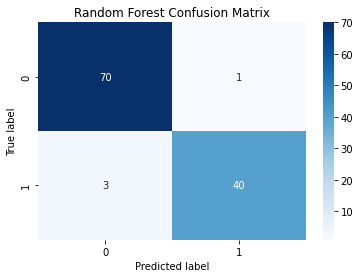

In [48]:
# Predict on test set and calculate accuracy
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rf_prec, rf_accuracy, rf_recall, rf_f1 = evaluate_model(y_test, y_pred_rf, "Random Forest")

True Negatives: 70

False Positives: 1

False Negatives: 3

True Positives: 40

## Feature Importance

In [49]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.13971333981326875, 'concave points_worst'),
 (0.12244813320331961, 'area_worst'),
 (0.11533220743928123, 'concave points_mean'),
 (0.11441049172818418, 'perimeter_worst'),
 (0.08250625427779008, 'radius_worst'),
 (0.051091160395859585, 'concavity_mean'),
 (0.04706475687207926, 'radius_mean'),
 (0.041768943622206234, 'perimeter_mean'),
 (0.040207440805062056, 'area_mean'),
 (0.03843478553502979, 'concavity_worst'),
 (0.029796888704994265, 'area_se'),
 (0.02100639840135993, 'texture_worst'),
 (0.016963074265710348, 'radius_se'),
 (0.016359326862804082, 'texture_mean'),
 (0.015939294523398435, 'compactness_worst'),
 (0.013318967818411364, 'symmetry_worst'),
 (0.01310910823606547, 'smoothness_worst'),
 (0.012101887153474402, 'compactness_mean'),
 (0.010395285249577283, 'perimeter_se'),
 (0.007545928120234165, 'concavity_se'),
 (0.007518062679254841, 'smoothness_mean'),
 (0.0061489633752481775, 'fractal_dimension_se'),
 (0.0058993364823716, 'fractal_dimension_worst'),
 (0.00532384903856

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

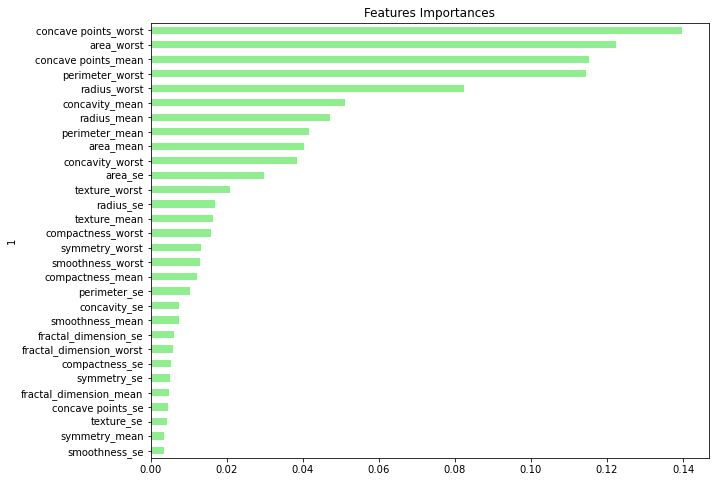

In [50]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', figsize=(10, 8),legend=False)

## Decision Tree Model

In [51]:
# Creating the decision tree classifier instance
from sklearn import tree
model = tree.DecisionTreeClassifier()

In [52]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

## Making Predictions Using the Tree Model


In [53]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

## Model Evaluation

Decision Tree Accuracy: 94.74%


Decision Tree Confusion Matrix:

[[68  3]
 [ 3 40]]


Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114





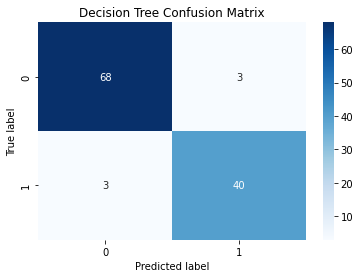

In [54]:
# Predict on test set and calculate accuracy
y_pred_dt = model.predict(X_test)

# Evaluate the Model
dt_prec, dt_accuracy, dt_recall, dt_f1 = evaluate_model(y_test, y_pred_dt, "Decision Tree")


True Negatives: 68

False Positives: 3

False Negatives: 3

True Positives: 40

Compared to the Random Forest this model gets more false negatives. Four cells have been identified as begnin when they are actually maligant. Whereas the Random Forest had only 1 false negative result. 

## Logistic Regression using original data 

In [25]:
# Create a Logistic Regression model with a higher maximum number of iterations
logreg = LogisticRegression(max_iter=5000)

# Fit the model to the breast cancer data
logreg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=5000)

Logistic Regression Accuracy: 97.37%


Logistic Regression Confusion Matrix:

[[70  1]
 [ 2 41]]


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114





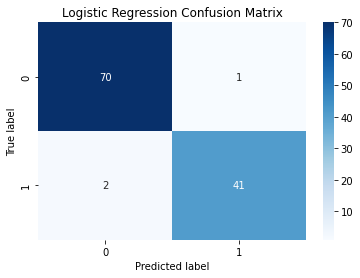

In [26]:
# Predict on test set and calculate accuracy
y_pred_log = logreg.predict(X_test_scaled)

# Evaluate the Model
linreg_prec, linreg_accuracy, linreg_recall, linreg_f1 = evaluate_model(y_test, y_pred_log, "Logistic Regression")


True Negatives: 70
    
False Positives: 1
    
False Negatives: 2
    
True Positives: 41

## Logistic Regression Model with Resampled Training Data

### Step 1: Use the RandomOverSampler module from the imbalanced-learn library to resample the data. Be sure to confirm that the labels have an equal number of data points.


In [55]:
# Import the RandomOverSampler module form imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [56]:
# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
random_oversampler_model = RandomOverSampler(random_state = 1)

In [57]:
# Fit the original training data to the random_oversampler model
X_rsample, y_rsample = random_oversampler_model.fit_resample(X_train, y_train)
# Count the distinct values of the resampled labels data
y_rsample.value_counts()

diagnosis
0    286
1    286
Name: count, dtype: int64

### Step 2: Use the LogisticRegression classifier and the resampled data to fit the model and make predictions.

In [58]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
sample_classifier = LogisticRegression(solver='lbfgs', random_state=1)

# Fit the model using training data
sample_classifier.fit(X_rsample, y_rsample)

# Make a prediction using the testing data
y_pred_log_balance = sample_classifier.predict(X_test)
pd.DataFrame({"Prediction": y_pred_log_balance, "Actual": y_test}).head()

,Prediction,Actual
204,0,0
70,1,1
131,1,1
431,0,0
540,0,0


### Step 3: Evaluate the model’s performance by doing the following:

* Calculate the accuracy score of the model.

* Generate a confusion matrix.

* Print the classification report.

R Logistic Regression Accuracy: 98.25%


R Logistic Regression Confusion Matrix:

[[70  1]
 [ 1 42]]


R Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114





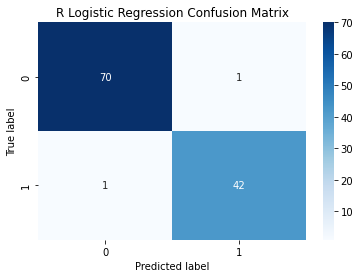

In [59]:
# Predict on test set and calculate accuracy
y_pred_log_balance = sample_classifier.predict(X_test)

# Evaluate the Model
linreg_prec_balance, linreg_accuracy_balance, linreg_recall_balance, linreg_f1_balance = evaluate_model(y_test, y_pred_log_balance, "R Logistic Regression")

True Negatives: 70
    
False Positives: 1
    
False Negatives: 1
    
True Positives: 42

## Support Vector Machine (SVM) using the 'linear' basis function kernel ("rbf")

In [32]:
# Initialize and fit SVM model
svmL = SVC(kernel='linear')
svmL.fit(X_train_scaled, y_train)

SVC(kernel='linear')

SVM_L Accuracy: 95.61%


SVM_L Confusion Matrix:

[[68  3]
 [ 2 41]]


SVM_L Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114





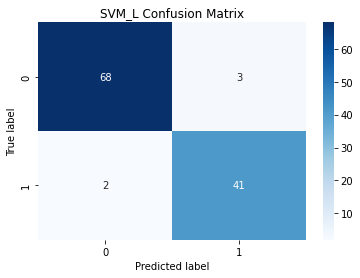

In [33]:
# Predict on test set and calculate accuracy
y_pred_svmL = svmL.predict(X_test_scaled)

# Evaluate the model
svml_precL, svml_accuracyL, svml_recallL, svml_f1L = evaluate_model(y_test, y_pred_svmL, "SVM_L")


True Negatives: 68
    
False Positives: 3
    
False Negatives: 2
    
True Positives: 41

## Support Vector Machine (SVM) using the radial basis function kernel ("rbf")

In [34]:
# Initialize and fit SVM model
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train_scaled, y_train)


SVC()

SVM_RBF Accuracy: 98.25%


SVM_RBF Confusion Matrix:

[[71  0]
 [ 2 41]]


SVM_RBF Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114





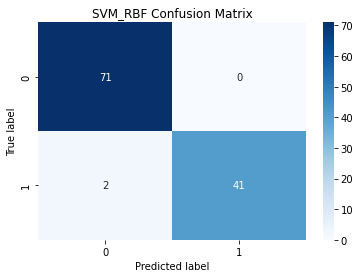

In [35]:
# Predict on test set and calculate accuracy
y_pred_svm = svm_rbf.predict(X_test_scaled)

# Evaluate the model
svm_prec, svm_accuracy, svm_recall, svm_f1 = evaluate_model(y_test, y_pred_svm, "SVM_RBF")


True Negatives: 71
    
False Positives: 0
    
False Negatives: 2
    
True Positives: 41

## Neural Networks

In [36]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
model = Sequential()
model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, nn_accuracy = model.evaluate(X_test, y_test)
print(f'\n\nTest loss: {loss:.4f}\nTest accuracy: {nn_accuracy*100:.2f}%\n\n')

Epoch 1/10
29/29 [==============================] - 3s 27ms/step - loss: 0.7438 - accuracy: 0.5670 - val_loss: 0.7054 - val_accuracy: 0.5702
Epoch 2/10
29/29 [==============================] - 0s 12ms/step - loss: 0.6879 - accuracy: 0.6725 - val_loss: 0.6500 - val_accuracy: 0.7456
Epoch 3/10
29/29 [==============================] - 0s 9ms/step - loss: 0.6374 - accuracy: 0.7451 - val_loss: 0.5791 - val_accuracy: 0.8509
Epoch 4/10
29/29 [==============================] - 0s 9ms/step - loss: 0.5733 - accuracy: 0.8549 - val_loss: 0.5082 - val_accuracy: 0.9035
Epoch 5/10
29/29 [==============================] - 0s 11ms/step - loss: 0.5165 - accuracy: 0.9055 - val_loss: 0.4671 - val_accuracy: 0.9561
Epoch 6/10
29/29 [==============================] - 0s 7ms/step - loss: 0.4830 - accuracy: 0.9187 - val_loss: 0.4435 - val_accuracy: 0.9649
Epoch 7/10
29/29 [==============================] - 0s 7ms/step - loss: 0.4606 - accuracy: 0.9319 - val_loss: 0.4289 - val_accuracy: 0.9649
Epoch 8/10
29/29 

4/4 [==============================] - 0s 3ms/step
Neural Network Accuracy: 96.49%


Neural Network Confusion Matrix:

[[67  4]
 [ 0 43]]


Neural Network Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        71
           1       0.91      1.00      0.96        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114





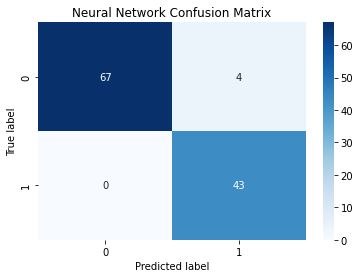

In [37]:
# Predict on test set and calculate accuracy
y_pred_proba = model.predict(X_test_scaled)
y_pred_nn = np.round(y_pred_proba).astype(int)


# Evaluate the Model

nn_prec, nn_accuracy, nn_recall, nn_f1 = evaluate_model(y_test, y_pred_nn, "Neural Network")


True Negatives: 67

False Positives: 4

False Negatives: 0

True Positives: 43

## Optimized Neural Network 1.1

In [38]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, opt_nn_accuracy = model.evaluate(X_test, y_test)
print(f'\n\nTest loss: {loss:.4f}\nTest accuracy: {opt_nn_accuracy*100:.2f}%\n\n')

Epoch 1/50
29/29 [==============================] - 3s 19ms/step - loss: 0.6659 - accuracy: 0.5187 - val_loss: 0.5528 - val_accuracy: 0.7719
Epoch 2/50
29/29 [==============================] - 0s 7ms/step - loss: 0.5085 - accuracy: 0.8462 - val_loss: 0.4141 - val_accuracy: 0.9386
Epoch 3/50
29/29 [==============================] - 0s 7ms/step - loss: 0.3757 - accuracy: 0.9209 - val_loss: 0.2865 - val_accuracy: 0.9737
Epoch 4/50
29/29 [==============================] - 0s 8ms/step - loss: 0.2599 - accuracy: 0.9429 - val_loss: 0.1931 - val_accuracy: 0.9737
Epoch 5/50
29/29 [==============================] - 0s 8ms/step - loss: 0.1854 - accuracy: 0.9495 - val_loss: 0.1416 - val_accuracy: 0.9825
Epoch 6/50
29/29 [==============================] - 0s 7ms/step - loss: 0.1443 - accuracy: 0.9560 - val_loss: 0.1167 - val_accuracy: 0.9737
Epoch 7/50
29/29 [==============================] - 0s 7ms/step - loss: 0.1192 - accuracy: 0.9692 - val_loss: 0.1006 - val_accuracy: 0.9649
Epoch 8/50
29/29 [=

4/4 [==============================] - 0s 2ms/step
Optimized Neural Network Accuracy: 97.37%


Optimized Neural Network Confusion Matrix:

[[69  2]
 [ 1 42]]


Optimized Neural Network Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114





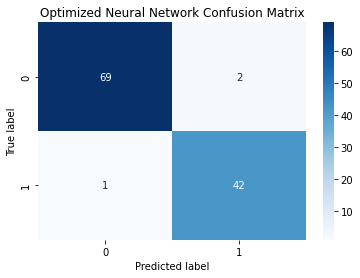

In [39]:
# Predict on test set and calculate accuracy
y_pred_proba = model.predict(X_test)
y_pred_opt_nn = np.round(y_pred_proba).astype(int)

# Evaluate the Model
opt_nn_prec, opt_nn_accuracy, opt_nn_recall, opt_nn_f1 = evaluate_model(y_test, y_pred_opt_nn, "Optimized Neural Network")

True Negatives: 69

False Positives: 2

False Negatives: 1

True Positives: 42

## Optimized Neural Network 1.2

In [60]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, opt2_nn_accuracy = model.evaluate(X_test, y_test)
print(f'\n\nTest loss: {loss:.4f}\nTest accuracy: {opt2_nn_accuracy*100:.2f}%\n\n')

Epoch 1/50
29/29 [==============================] - 2s 15ms/step - loss: 0.7612 - accuracy: 0.3714 - val_loss: 0.7220 - val_accuracy: 0.3772
Epoch 2/50
29/29 [==============================] - 0s 6ms/step - loss: 0.6989 - accuracy: 0.3758 - val_loss: 0.6718 - val_accuracy: 0.4298
Epoch 3/50
29/29 [==============================] - 0s 6ms/step - loss: 0.6549 - accuracy: 0.8330 - val_loss: 0.6345 - val_accuracy: 0.9123
Epoch 4/50
29/29 [==============================] - 0s 7ms/step - loss: 0.6212 - accuracy: 0.9011 - val_loss: 0.6050 - val_accuracy: 0.8333
Epoch 5/50
29/29 [==============================] - 0s 7ms/step - loss: 0.5930 - accuracy: 0.8527 - val_loss: 0.5774 - val_accuracy: 0.8333
Epoch 6/50
29/29 [==============================] - 0s 7ms/step - loss: 0.5655 - accuracy: 0.8659 - val_loss: 0.5481 - val_accuracy: 0.8684
Epoch 7/50
29/29 [==============================] - 0s 6ms/step - loss: 0.5364 - accuracy: 0.9055 - val_loss: 0.5168 - val_accuracy: 0.9035
Epoch 8/50
29/29 [=

4/4 [==============================] - 0s 3ms/step
Optimized Neural Network Accuracy: 99.12%


Optimized Neural Network Confusion Matrix:

[[71  0]
 [ 1 42]]


Optimized Neural Network Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        71
           1       1.00      0.98      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114





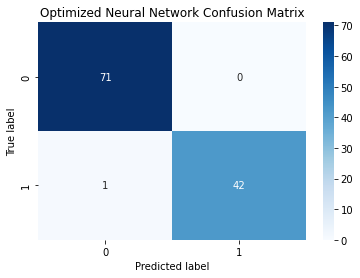

In [61]:
# Predict on test set and calculate accuracy
y_pred_proba = model.predict(X_test)
y_pred_opt2_nn = np.round(y_pred_proba).astype(int)

# Evaluate the Model
opt2_nn_prec, opt2_nn_accuracy, opt2_nn_recall, opt2_nn_f1 = evaluate_model(y_test, y_pred_opt2_nn, "Optimized Neural Network")

True Negatives: 71

False Positives: 0

False Negatives: 1

True Positives: 42

## Score Comparison 

In [62]:
# Create list of models and scores
models_list = ['Random Forest','Decision Tree','Logistic Regression', 'SVM', 'Optimized Neural Network']
accuracy_list = [rf_accuracy,dt_accuracy,linreg_accuracy_balance, svm_accuracy, opt2_nn_accuracy]
precision_list = [rf_prec,dt_prec,linreg_prec_balance, svm_prec, opt2_nn_prec]
recall_list = [rf_recall,dt_recall,linreg_recall_balance, svm_recall, opt2_nn_recall]
f1_list = [rf_f1,dt_f1,linreg_f1_balance, svm_f1, opt2_nn_f1]

# Create score dataframe
score_df = pd.DataFrame({
    'Models': models_list,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-score': f1_list
})

# Modify numerical columns to be in % with 2 decimal points
score_df[['Accuracy', 'Precision', 'Recall', 'F1-score']] = score_df[['Accuracy', 'Precision', 'Recall', 'F1-score']].apply(lambda x: round(x * 100, 2))
score_df

,Models,Accuracy,Precision,Recall,F1-score
0,Random Forest,96.49,96.73,95.81,96.23
1,Decision Tree,94.74,94.40,94.40,94.40
2,Logistic Regression,98.25,98.13,98.13,98.13
3,SVM,98.25,98.63,97.67,98.12
4,Optimized Neural Network,99.12,99.31,98.84,99.06


In [63]:
# Save the dataframe to a CSV file
score_df.to_csv('Resources/score.csv', index=False)

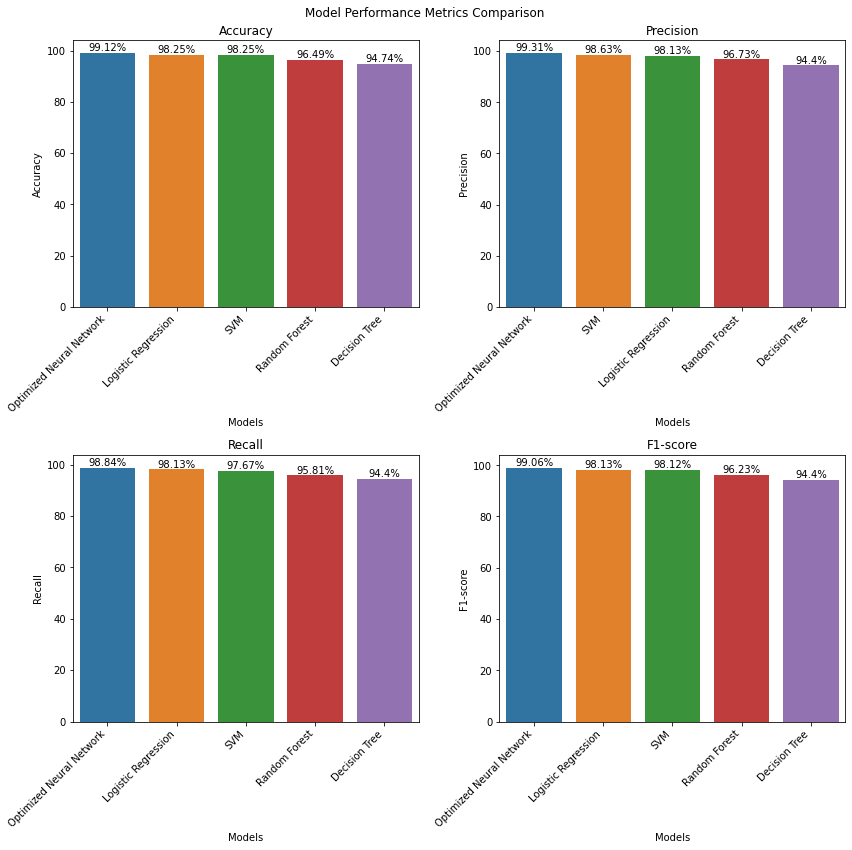

In [64]:
# Create a 2x2 plot to compare all the scores
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Model Performance Metrics Comparison')

# Plot Accuracy
accuracy_sorted = score_df.sort_values(by='Accuracy', ascending=False)
sns.barplot(ax=axes[0, 0], x='Models', y='Accuracy', data=accuracy_sorted)
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, horizontalalignment='right')
for i, v in enumerate(accuracy_sorted['Accuracy']):
    axes[0, 0].text(i, v, f"{v}%", ha='center', va='bottom', fontsize=10)

# Plot Precision
precision_sorted = score_df.sort_values(by='Precision', ascending=False)
sns.barplot(ax=axes[0, 1], x='Models', y='Precision', data=precision_sorted)
axes[0, 1].set_title('Precision')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, horizontalalignment='right')
for i, v in enumerate(precision_sorted['Precision']):
    axes[0, 1].text(i, v, f"{v}%", ha='center', va='bottom', fontsize=10)

# Plot Recall
recall_sorted = score_df.sort_values(by='Recall', ascending=False)
sns.barplot(ax=axes[1, 0], x='Models', y='Recall', data=recall_sorted)
axes[1, 0].set_title('Recall')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, horizontalalignment='right')
for i, v in enumerate(recall_sorted['Recall']):
    axes[1, 0].text(i, v, f"{v}%", ha='center', va='bottom', fontsize=10)

# Plot F1-score
f1_sorted = score_df.sort_values(by='F1-score', ascending=False)
sns.barplot(ax=axes[1, 1], x='Models', y='F1-score', data=f1_sorted)
axes[1, 1].set_title('F1-score')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, horizontalalignment='right')
for i, v in enumerate(f1_sorted['F1-score']):
    axes[1, 1].text(i, v, f"{v}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()